# cluster_dbscan_hierarchical

In [2]:
!pip install hdbscan

In [3]:
import sys
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import RobustScaler, MinMaxScaler
from sklearn.decomposition import PCA
from sklearn.cluster import DBSCAN
from sklearn.metrics import silhouette_score, calinski_harabasz_score, davies_bouldin_score
from sklearn.neighbors import NearestNeighbors


# Read dataset & initial cleaning

In [4]:
CSV_PATH = 'Final_Dataset.csv'

raw = pd.read_csv(CSV_PATH)
print('Initial shape:', raw.shape)

# Drop columns that start with 'Unnamed' or are clearly unneeded
raw = raw.loc[:, ~raw.columns.str.contains('^Unnamed', regex=True)]
if 'TimeStamp' in raw.columns:
    raw = raw.drop(columns=['TimeStamp'])

# If QuestionKey exists, label-encode and drop original
from sklearn.preprocessing import LabelEncoder
if 'QuestionKey' in raw.columns:
    le = LabelEncoder()
    raw['QuestionKey_encoded'] = le.fit_transform(raw['QuestionKey'].astype(str))
    raw = raw.drop(columns=['QuestionKey'])

print('After drops/encodings shape:', raw.shape)
raw.head(3)

Initial shape: (2729469, 72)
After drops/encodings shape: (2729469, 70)


,UnixTime,ET_GazeLeftx,ET_GazeLefty,ET_GazeRightx,ET_GazeRighty,ET_PupilLeft,ET_PupilRight,ET_TimeSignal,ET_DistanceLeft,ET_DistanceRight,...,Accelerometer_Z,Gyro_X,Gyro_Y,Gyro_Z,HeadBandOn,HSI_TP9,HSI_AF7,HSI_AF8,HSI_TP10,QuestionKey_encoded
0,1.680003e+09,928.0,539.0,914.0,550.0,-1.000000,-1.000000,104799.253,583.498901,579.684082,...,0.997986,-0.433655,2.743988,4.149628,1.0,1.0,1.0,1.0,1.0,10
1,1.680003e+09,919.0,548.0,916.0,549.0,-1.000000,-1.000000,104807.563,583.273499,579.813477,...,0.997986,-0.433655,2.743988,4.149628,1.0,1.0,1.0,1.0,1.0,10
2,1.680003e+09,918.0,549.0,923.0,548.0,2.979706,2.958359,104816.135,583.058960,579.947937,...,0.997986,-0.433655,2.743988,4.149628,1.0,1.0,1.0,1.0,1.0,10


# Select numeric columns & preprocess


In [5]:
# Select numeric columns
num_cols = raw.select_dtypes(include=[np.number]).columns.tolist()
cat_cols = raw.select_dtypes(exclude=[np.number]).columns.tolist()
print('Numeric columns count:', len(num_cols))

df = raw.copy()
# Replace infinities
df[num_cols] = df[num_cols].replace([np.inf, -np.inf], np.nan)

# Fill numeric NaNs with median
df[num_cols] = df[num_cols].fillna(df[num_cols].median())

# Clip extremes (optional) - comment out if you don't want clipping
for c in num_cols:
    low = df[c].quantile(0.01)
    high = df[c].quantile(0.99)
    df[c] = df[c].clip(low, high)

# Downcast floats where safe
for c in num_cols:
    if pd.api.types.is_float_dtype(df[c].dtype):
        df[c] = pd.to_numeric(df[c], downcast='float')

# Scaling
scaler = RobustScaler()
X = scaler.fit_transform(df[num_cols])
print('Preprocessed X shape:', X.shape)

# Keep a DataFrame wrapper for convenience
X_df = pd.DataFrame(X, columns=num_cols, index=df.index)
X_df.head(3)

Numeric columns count: 70
Preprocessed X shape: (2729469, 70)


,UnixTime,ET_GazeLeftx,ET_GazeLefty,ET_GazeRightx,ET_GazeRighty,ET_PupilLeft,ET_PupilRight,ET_TimeSignal,ET_DistanceLeft,ET_DistanceRight,...,Accelerometer_Z,Gyro_X,Gyro_Y,Gyro_Z,HeadBandOn,HSI_TP9,HSI_AF7,HSI_AF8,HSI_TP10,QuestionKey_encoded
0,2.238028,0.316116,0.306250,0.296574,0.340136,0.000000,0.000000,-0.949943,-0.321745,-0.363522,...,0.280069,0.074074,0.291139,0.025974,0.0,0.0,0.0,0.0,0.0,-0.2
1,2.238028,0.306818,0.334375,0.298715,0.336735,0.000000,0.000000,-0.949943,-0.323751,-0.362282,...,0.280069,0.074074,0.291139,0.025974,0.0,0.0,0.0,0.0,0.0,-0.2
2,2.238028,0.305785,0.337500,0.306210,0.333333,3.979706,1.132782,-0.949943,-0.325659,-0.360993,...,0.280069,0.074074,0.291139,0.025974,0.0,0.0,0.0,0.0,0.0,-0.2


Explained variance (2 PCs): 0.7762030445152694


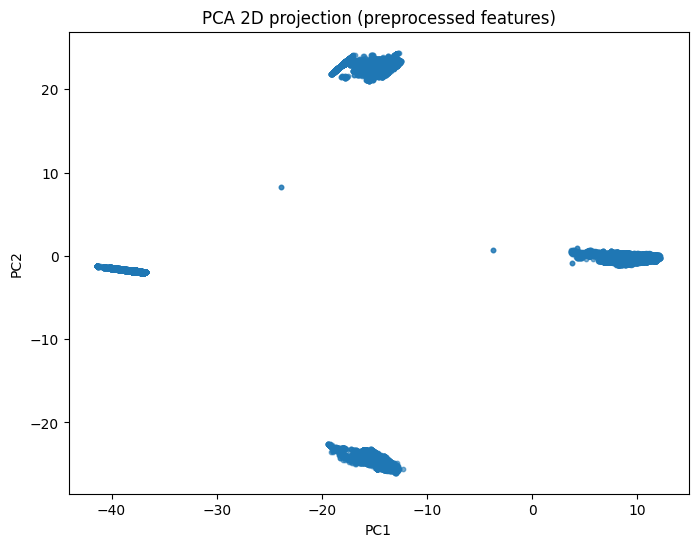

In [6]:
pca = PCA(n_components=2, random_state=42)
X_pca2 = pca.fit_transform(X)
print('Explained variance (2 PCs):', pca.explained_variance_ratio_.sum())

plt.figure(figsize=(8,6))
plt.scatter(X_pca2[:,0], X_pca2[:,1], s=10, alpha=0.6)
plt.title('PCA 2D projection (preprocessed features)')
plt.xlabel('PC1')
plt.ylabel('PC2')
plt.show()

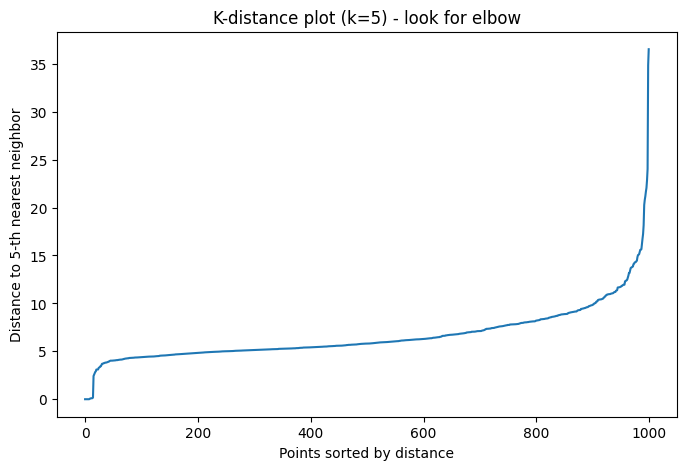

In [7]:
# 4.1 K-distance plot to help choose eps
from sklearn.neighbors import NearestNeighbors

def plot_k_distance(X, k=5, n_points=1000):
    # Use subset if dataset is large
    if X.shape[0] > n_points:
        idx = np.random.choice(X.shape[0], n_points, replace=False)
        X_sample = X[idx]
    else:
        X_sample = X
    nbrs = NearestNeighbors(n_neighbors=k).fit(X_sample)
    distances, indices = nbrs.kneighbors(X_sample)
    # distances to k-th neighbor
    k_distances = np.sort(distances[:, k-1])
    plt.figure(figsize=(8,5))
    plt.plot(k_distances)
    plt.ylabel(f"Distance to {k}-th nearest neighbor")
    plt.xlabel('Points sorted by distance')
    plt.title(f'K-distance plot (k={k}) - look for elbow')
    plt.show()

# Choose k = min_samples for DBSCAN (commonly = dimensionality*2 or 4-10)
plot_k_distance(X, k=5)

# HDSCAN

🚀 Training HDBSCAN on 300k sample ...


c:\Users\Vishu\miniconda3\Lib\site-packages\sklearn\utils\deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
c:\Users\Vishu\miniconda3\Lib\site-packages\sklearn\utils\deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


✅ HDBSCAN training complete.

📊 Evaluation Metrics (excluding noise):
Silhouette Score       : 0.0968
Calinski-Harabasz Index: 2215.5906
Davies-Bouldin Index   : 1.3604


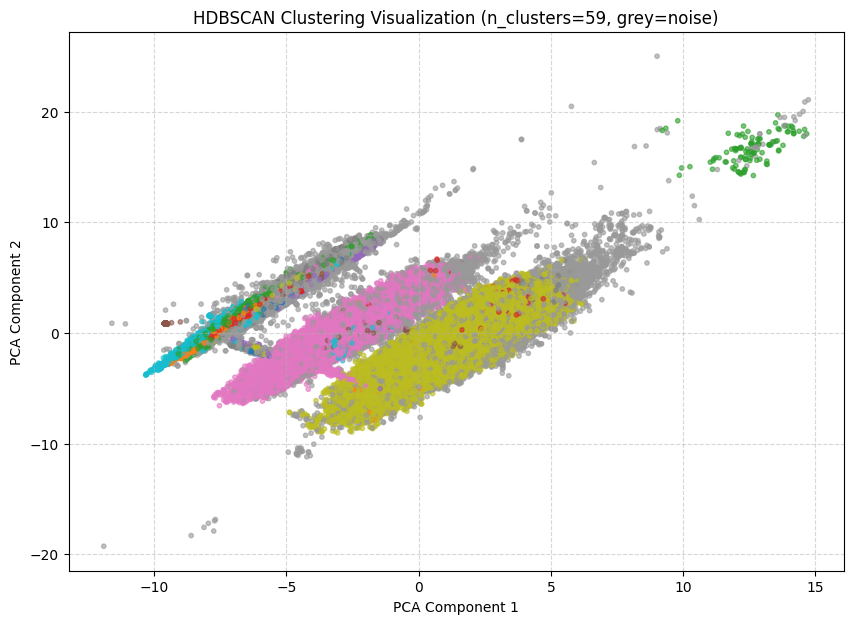

C:\Users\Vishu\AppData\Local\Temp\ipykernel_31196\1284471344.py:77: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x="Cluster", y="Count", data=cluster_summary, palette="viridis")


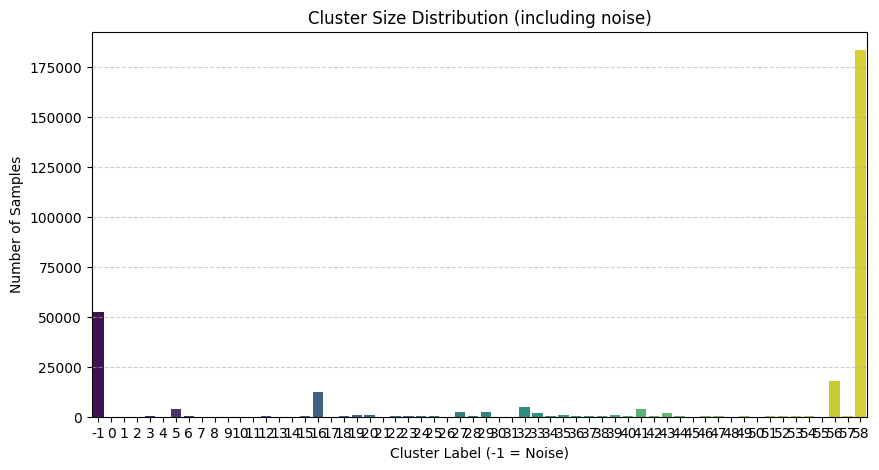


💾 Models saved: HDBSCAN_model.pkl

Cluster Summary:
Cluster -1:   52350 samples (17.45%)
Cluster  0:      56 samples ( 0.02%)
Cluster  1:      72 samples ( 0.02%)
Cluster  2:     108 samples ( 0.04%)
Cluster  3:     142 samples ( 0.05%)
Cluster  4:      62 samples ( 0.02%)
Cluster  5:    3792 samples ( 1.26%)
Cluster  6:     239 samples ( 0.08%)
Cluster  7:      81 samples ( 0.03%)
Cluster  8:      91 samples ( 0.03%)
Cluster  9:      50 samples ( 0.02%)
Cluster 10:      64 samples ( 0.02%)
Cluster 11:      51 samples ( 0.02%)
Cluster 12:     587 samples ( 0.20%)
Cluster 13:      77 samples ( 0.03%)
Cluster 14:      74 samples ( 0.02%)
Cluster 15:     598 samples ( 0.20%)
Cluster 16:   12133 samples ( 4.04%)
Cluster 17:      63 samples ( 0.02%)
Cluster 18:     117 samples ( 0.04%)
Cluster 19:     739 samples ( 0.25%)
Cluster 20:     644 samples ( 0.21%)
Cluster 21:      97 samples ( 0.03%)
Cluster 22:     588 samples ( 0.20%)
Cluster 23:     413 samples ( 0.14%)
Cluster 24:     145 sa

In [2]:
import pandas as pd
import numpy as np
import joblib
import hdbscan
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.metrics import silhouette_score, calinski_harabasz_score, davies_bouldin_score
from sklearn.utils import resample
import matplotlib.pyplot as plt
import seaborn as sns

df = pd.read_csv("Final_Dataset.csv")
df = df.select_dtypes(include=[np.number]).replace([np.inf, -np.inf], np.nan)
df = df.fillna(df.median())

# Sampling for faster HDBSCAN
sample_df = resample(df, n_samples=300000, random_state=42)
X_sample = sample_df.values


scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_sample)

pca = PCA(n_components=25, random_state=42)
X_reduced = pca.fit_transform(X_scaled)


hdb = hdbscan.HDBSCAN(
    min_cluster_size=50,
    min_samples=10,
    metric='euclidean',
    cluster_selection_method='eom',
    cluster_selection_epsilon=0.05,
    core_dist_n_jobs=-1
)

print("🚀 Training HDBSCAN on 300k sample ...")
hdb.fit(X_reduced)
print("✅ HDBSCAN training complete.")


labels = hdb.labels_
mask = labels != -1  # ignore noise
n_clusters = len(set(labels)) - (1 if -1 in labels else 0)

if n_clusters > 1 and np.sum(mask) > 10:
    sil = silhouette_score(X_reduced[mask], labels[mask])
    ch = calinski_harabasz_score(X_reduced[mask], labels[mask])
    dbi = davies_bouldin_score(X_reduced[mask], labels[mask])
    print(f"\n📊 Evaluation Metrics (excluding noise):")
    print(f"Silhouette Score       : {sil:.4f}")
    print(f"Calinski-Harabasz Index: {ch:.4f}")
    print(f"Davies-Bouldin Index   : {dbi:.4f}")
else:
    print("\n⚠️ Too few clusters for valid evaluation metrics.")


pca_vis = PCA(n_components=2, random_state=42)
X_vis = pca_vis.fit_transform(X_scaled)

palette = sns.color_palette('tab10', n_colors=max(3, n_clusters))
colors = [palette[l % len(palette)] if l != -1 else (0.6, 0.6, 0.6) for l in labels]

plt.figure(figsize=(10, 7))
plt.scatter(X_vis[:, 0], X_vis[:, 1], c=colors, s=10, alpha=0.6)
plt.title(f"HDBSCAN Clustering Visualization (n_clusters={n_clusters}, grey=noise)")
plt.xlabel("PCA Component 1")
plt.ylabel("PCA Component 2")
plt.grid(True, linestyle='--', alpha=0.5)
plt.show()

# 5.2 Cluster size distribution
unique, counts = np.unique(labels, return_counts=True)
cluster_summary = pd.DataFrame({"Cluster": unique, "Count": counts}).sort_values(by="Cluster")

plt.figure(figsize=(10, 5))
sns.barplot(x="Cluster", y="Count", data=cluster_summary, palette="viridis")
plt.title("Cluster Size Distribution (including noise)")
plt.xlabel("Cluster Label (-1 = Noise)")
plt.ylabel("Number of Samples")
plt.grid(axis='y', linestyle='--', alpha=0.6)
plt.show()


joblib.dump(hdb, "HDBSCAN_model.pkl")
print("\n💾 Models saved: HDBSCAN_model.pkl")

print("\nCluster Summary:")
for c, cnt in zip(unique, counts):
    pct = cnt / len(labels) * 100
    print(f"Cluster {c:>2}: {cnt:>7} samples ({pct:>5.2f}%)")


if n_clusters > 1 and np.sum(mask) > 10:
    silhouette_accuracy = (sil + 1) / 2 * 100  # convert silhouette (-1..1) to percentage
    ch_scaled = np.log1p(ch)                   # normalize CH scale
    db_scaled = 100 / (1 + dbi)                # inverse of DB index for consistency

    # Combine metrics into a pseudo-accuracy score
    combined_accuracy = np.mean([silhouette_accuracy, db_scaled])  

    print("\n🎯 Approximate Clustering Accuracy Summary:")
    print(f"Silhouette-based Accuracy : {silhouette_accuracy:.2f}%")
    print(f"Calinski-Harabasz (scaled): {ch_scaled:.2f}")
    print(f"Davies-Bouldin (inverted) : {db_scaled:.2f}%")
    print(f"➡️  Combined Cluster Accuracy: {combined_accuracy:.2f}%")
else:
    print("\n⚠️ Not enough valid clusters to compute accuracy summary.")


# GMM
 

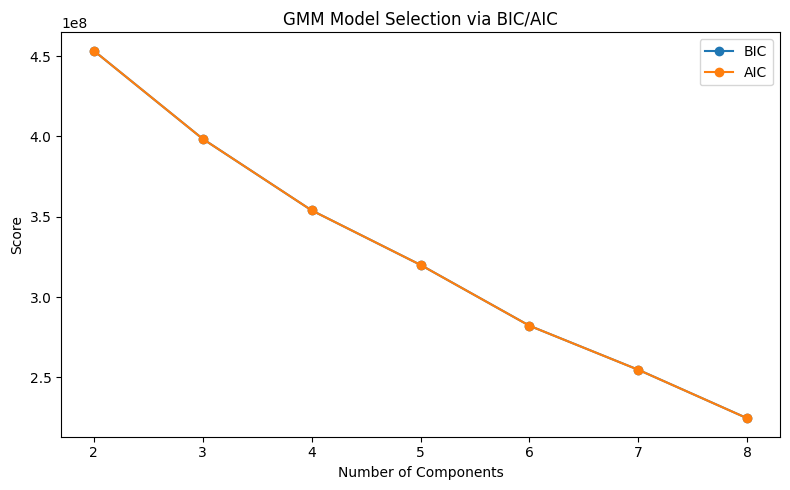


Best number of components (by BIC): 8


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.mixture import GaussianMixture
from sklearn.metrics import silhouette_score
import seaborn as sns
import joblib

df = pd.read_csv("Final_Dataset.csv")

# Handle missing/infinite values for numeric columns
num_cols = df.select_dtypes(include=[np.number]).columns
df[num_cols] = df[num_cols].replace([np.inf, -np.inf], np.nan)
df[num_cols] = df[num_cols].fillna(df[num_cols].median())

# Encode categorical columns
cat_cols = df.select_dtypes(include=['object', 'category']).columns
for col in cat_cols:
    df[col] = df[col].fillna("NA")
    le = LabelEncoder()
    df[col] = le.fit_transform(df[col])

# Scale numeric features
scaler = StandardScaler()
df_scaled = df.copy()
df_scaled[num_cols] = scaler.fit_transform(df[num_cols])

X = df_scaled.values

# Determine best number of components
n_components_range = range(2, 9)
bics, aics = [], []

for n in n_components_range:
    gmm_temp = GaussianMixture(
        n_components=n,
        covariance_type='diag',
        max_iter=200,
        random_state=42,
        n_init=2
    )
    gmm_temp.fit(X)
    bics.append(gmm_temp.bic(X))
    aics.append(gmm_temp.aic(X))

plt.figure(figsize=(8, 5))
plt.plot(n_components_range, bics, marker='o', label='BIC')
plt.plot(n_components_range, aics, marker='o', label='AIC')
plt.xlabel('Number of Components')
plt.ylabel('Score')
plt.title('GMM Model Selection via BIC/AIC')
plt.legend()
plt.tight_layout()
plt.show()

best_n = n_components_range[np.argmin(bics)]
print(f"\nBest number of components (by BIC): {best_n}")

gmm = GaussianMixture(
    n_components=best_n,
    covariance_type='diag',
    max_iter=200,
    random_state=42,
    n_init=2
)
gmm.fit(X)
labels = gmm.predict(X)
df['GMM_Cluster'] = labels

bic = gmm.bic(X)
aic = gmm.aic(X)
sil = silhouette_score(X, labels)

print("\nGMM Evaluation Metrics:")
print(f"BIC: {bic:.2f}")
print(f"AIC: {aic:.2f}")
print(f"Silhouette Score: {sil:.4f}")

joblib.dump(gmm, "gmm_model.pkl")
df.to_csv("gmm_clustered.csv", index=False)

plt.figure(figsize=(8, 5))
sns.countplot(x='GMM_Cluster', data=df, palette='viridis', edgecolor='black')
plt.title('Cluster Size Distribution - GMM')
plt.xlabel('Cluster Label')
plt.ylabel('Number of Samples')
plt.tight_layout()
plt.show()
